## Notebook to reproduce results from Pistachio BERT

In [2]:
# To reproduce Pistahcio BERT results in notebook use environment defined in https://github.com/rxn4chemistry/rxnfp

import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os  
import json
import sys
from rdkit.Chem import MolFromSmiles, MolToSmiles

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

import torch
import pkg_resources
import pandas as pd
import math

from rxnfp.models import SmilesClassificationModel

sys.path.insert(0, "../../BEE")
sys.path.insert(0, "../reaction_transformers")
from reaction_transformers.tokenization import smi_tokenizer

from reaction_transformers.input_output_processing import split_data, convert_strlst2lstfloat, replace_sep, add_photocat_react_ids, nested_cross_validation, \
                                                          get_folder_names, sort_reactants, add_canonical_rxn_smiles, moving_avg, epochs_calc_r2, r2score_stats

from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
#id to role is not necessary for use of the pistachio pretrained model
#in this notebook it is used indirectly to identify entities in the reaction smiles so canonicalization can be applied at entity level
#traditional canonicalization methods can be used instead
ID2ROLE = {"1": "aryl_halides", "2":"solvent", "3": "photocalysts", "4": "piperidines", "5":"catalysts", "6":"ni_catalysts"}

In [4]:
def inference_record_performance(file_name, base_model, col_input, epoch_offset = 20, final_epoch = 340, stride = 20, split_num = 5):

    r2_scores_all = {}
    max_r2_scores_all = {}
    for i in range(split_num):
        photoredox_merck_5_splitted = split_data(df_photoredox_merck, math.ceil(len(df_photoredox_merck)/split_num))
        val_test = photoredox_merck_5_splitted.pop(i)
        test = val_test.iloc[:int(len(val_test)/2)]

        model_dir = f"../results/{base_model}_{file_name}_ncv_{i}"
        r2_scores = epochs_calc_r2(test[col_input], model_dir, checkpoit_multiple=22, epoch_offset = epoch_offset, final_epoch = final_epoch, stride = stride)
        r2_scores_all[f"ncv_{i}"] = r2_scores
        max_r2_scores_all[f"ncv_{i}"] = max(moving_avg(list(r2_scores.values()), sig_range = 3))

    data = [max_r2_scores_all, r2_scores_all]
    data_json = json.dumps(data, indent=2)

    with open(f"../results/{base_model}_{file_name}_ncv_results.json", "w") as outfile:
        outfile.write(data_json)
    
    print(f"Finished generating and saving JSON result files to /results/{base_model}_{file_name}_ncv_results.json")
    
def train_save(df_photoredox, split_num, model_path, file_name, model_args, col_input):
    
    for i in range(split_num):
        photoredox_splits = split_data(df_photoredox, math.ceil(len(df_photoredox)/split_num))
        val_test = photoredox_splits.pop(i)
        train = pd.concat(photoredox_splits)
        val = val_test.iloc[int(len(val_test)/2):]
        test = val_test.iloc[:int(len(val_test)/2)]

        output_dir = f"fine_tuned_models/{base_model}_{file_name}_ncv_{i}"

        pretrained_bert = SmilesClassificationModel("bert", model_path, num_labels=1, args=model_args, use_cuda=torch.cuda.is_available())
        pretrained_bert.train_model(train[col_input], output_dir=output_dir, show_running_loss=False, eval_df=val[col_input])
        
    print(f"Finished training and saving models to fine_tuned_models/{base_model}_{file_name}_ncv")
    
    
def load_prepare_data(data_path):
    """
    Load .csv into dataframe and process data into ML ready format
    """
    df_photoredox = pd.read_csv(data_path, index_col = 0)
    
    #Reactant ids will be used for SMILES standardization purposes.
    df_photoredox["reactant_ids_order"] = df_photoredox.progress_apply(lambda row: convert_strlst2lstfloat(row["reactant_ids_order"]), axis = 1)
    df_photoredox["reactant_ids_order"] = df_photoredox.progress_apply(lambda row: add_photocat_react_ids(row, ID2ROLE), axis = 1)

    df_photoredox["reaction_smiles_sep"] = df_photoredox.apply(lambda row: replace_sep(row), axis = 1)
    
    df_photoredox["labels"] = df_photoredox['uplcms'].apply(lambda uplcms: uplcms/100)
    df_photoredox = add_canonical_rxn_smiles(df_photoredox)
    df_photoredox.rename(columns={"rxns_canonical_rdkit":"text"}, inplace = True)
    df_photoredox = df_photoredox.sample(frac = 1, random_state = 42)

    return df_photoredox

In [146]:
df_photoredox = load_prepare_data(data_path = '../data/"Photoredox_rxns.csv"')

base_model = "pretrained"
model_path = pkg_resources.resource_filename("rxnfp", f"models/transformers/bert_{base_model}")
file_name = "photoredox_1700"
split_num = 5
dropout = 0.75
l_r = 0.00001
model_args = { 'num_train_epochs': 100, 'overwrite_output_dir': True, #"save_epochs": 20,
                'learning_rate': l_r, 'gradient_accumulation_steps': 1,
                'regression': True, "num_labels":1, "fp16": False,
                "evaluate_during_training": True, 'manual_seed': 42,
                "max_seq_length": 350, "train_batch_size": 64,"warmup_ratio": 0.00,
                "config" : {'hidden_dropout_prob': dropout}}
col_input = ["text","labels"]

train_save(df_photoredox, split_num, model_path, file_name, model_args, col_input)

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

/home/pneves6/.conda/envs/yields/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/home/pneves6/.conda/envs/yields/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1384 [00:00<?, ?it/s]

Epoch:   0%|          | 0/340 [00:00<?, ?it/s]

In [ ]:
file_name = "photoredox_1700_start"
model_args = { 'num_train_epochs': 18, 'overwrite_output_dir': True, #"save_epochs": 2,
                'learning_rate': l_r, 'gradient_accumulation_steps': 1,
                'regression': True, "num_labels":1, "fp16": False,
                "evaluate_during_training": True, 'manual_seed': 42,
                "max_seq_length": 350, "train_batch_size": 64,"warmup_ratio": 0.00,
                "config" : {'hidden_dropout_prob': dropout}}

train_save(df_photoredox, split_num, model_path, file_name, model_args, col_input)

In [ ]:
df_photoredox_merck = load_prepare_data(data_path = '../data)
file_name = "photoredox_1700"
epoch_offset = 20; final_epoch = 120; stride = 20, split_num = 5                                        
inference_record_performance(file_name, base_model, col_input, epoch_offset, final_epoch, stride)

In [ ]:
#df_photoredox_merck = load_prepare_data(data_path = '../data)
file_name = "photoredox_1700_start"
epoch_offset = 0; final_epoch = 18; stride = 2, split_num = 5                                        
inference_record_performance(file_name, base_model, col_input, epoch_offset, final_epoch, stride)

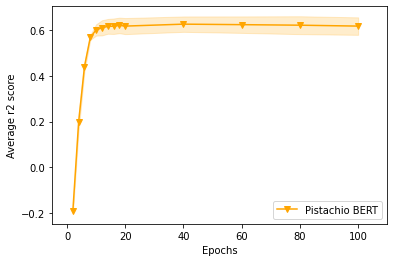

In [20]:
with open (f"results/pretrained_photoredox_1700_ncv_start_results.json", "r") as json_data:
    r2_scores_start_all = json.loads(json_data.read())

with open (f"results/pretrained_photoredox_1700_ncv_results.json", "r") as json_data:
    r2_scores_all = json.loads(json_data.read())

r2_start_all_avg, r2_start_all_min, r2_start_all_max, r2_start_all_std = r2score_stats(r2_scores_start_all[1])    
r2_all_avg, r2_all_min, r2_all_max, r2_all_std = r2score_stats(r2_scores_all[1])

r2_all_avg = r2_start_all_avg+r2_all_avg; r2_all_min = r2_start_all_min+r2_all_min; r2_all_max = r2_start_all_max+r2_all_max;r2_all_std = r2_start_all_std + r2_all_std

epochs_start = [int(ep.split("_")[1]) for ep in list(r2_scores_start_all[1]["ncv_0"].keys())]
epochs = [int(ep.split("_")[1]) for ep in list(r2_scores_all[1]["ncv_0"].keys())]
epochs = epochs_start+epochs

plt.plot(epochs[:14], r2_all_avg[:14], marker='v', color='orange', label = "Pistachio BERT")
plt.fill_between(epochs[:14], [i-j for i,j in zip(r2_all_avg[:14], r2_all_std[:14])], [i+j for i,j in zip(r2_all_avg[:14],r2_all_std[:14])], color='orange', alpha=0.2)
plt.xlim(-5,110)
plt.xlabel("Epochs")
plt.ylabel("Average r2 score")
plt.legend(loc = 'lower right')
plt.show()